In [10]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sensors import *

In [11]:
def err(G, sensors, labels, i):
    preds = flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [30]:
def corr(G, sensors, labels, i):
    preds = dict2vect(G, flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]}))
    actual = dict2vect(G, labels)
    return np.corrcoef(actual, preds)[1,0]

In [34]:
def plot_results(G, labeled_flows, ratio, samples=100):
    k = int(G.number_of_edges() * ratio)
    
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    rb_sensors = al_flows_rb(G, ratio)
    greedy_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)
    
#     if len(rb_sensors) != len(greedy_sensors):
#         print("error: expected", len(greedy_sensors), "edges but got", len(set(rb_sensors)))
        
#     if len(set(rb_sensors)) != len(rb_sensors):
#         for i, e in enumerate(rb_sensors):
#             for j, f in enumerate(rb_sensors):
#                 if e == f and i != j:
#                     print(e, f, "repeated")
#         return
    
    greedy_err, rand_err, rrqr_err, rb_err = {}, {}, {}, {}
    greedy_corr, rand_corr, rrqr_corr, rb_corr = {}, {}, {}, {}

    for j in tqdm(range(samples)):
        i = int(k * j / samples)
        
        greedy_err[i] = err(G, greedy_sensors, labeled_flows, i)
        rand_err[i] = err(G, random_sensors, labeled_flows, i)
        rrqr_err[i] = err(G, rrqr_sensors, labeled_flows, i)
        rb_err[i] = err(G, rb_sensors, labeled_flows, i)
        
        greedy_corr[i] = corr(G, greedy_sensors, labeled_flows, i)
        rand_corr[i] = corr(G, random_sensors, labeled_flows, i)
        rrqr_corr[i] = corr(G, rrqr_sensors, labeled_flows, i)
        rb_corr[i] = corr(G, rb_sensors, labeled_flows, i)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    ax1.plot([k / G.number_of_edges() for k in greedy_err.keys()], greedy_err.values(), "b", label="Greedy")
    ax1.plot([k / G.number_of_edges() for k in rand_err.keys()], rand_err.values(), "r", label="Random")
    ax1.plot([k / G.number_of_edges() for k in rrqr_err.keys()], rrqr_err.values(), "g", label="RRQR")
    ax1.plot([k / G.number_of_edges() for k in rb_err.keys()], rb_err.values(), "m", label="RB")
    
    ax1.legend()
    ax1.set_xlabel("Ratio Labeled")
    ax1.set_ylabel("MSE")
    ax1.grid("on")
    
    ax2.plot([k / G.number_of_edges() for k in greedy_corr.keys()], greedy_corr.values(), "b", label="Greedy")
    ax2.plot([k / G.number_of_edges() for k in rand_corr.keys()], rand_corr.values(), "r", label="Random")
    ax2.plot([k / G.number_of_edges() for k in rrqr_corr.keys()], rrqr_corr.values(), "g", label="RRQR")
    ax2.plot([k / G.number_of_edges() for k in rb_corr.keys()], rb_corr.values(), "m", label="RB")
    
    ax2.legend()
    ax2.set_xlabel("Ratio Labeled")
    ax2.set_ylabel("Correlation")
    ax2.grid("on")

In [36]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    plot_results(G, labeled_flows, 1, 100)

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


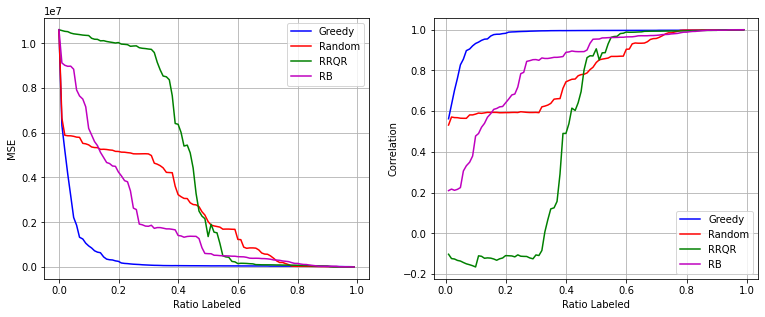

In [35]:
read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
#plt.savefig("results/Anaheim_MSE.pdf")
plt.show()

  0%|          | 0/2522 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


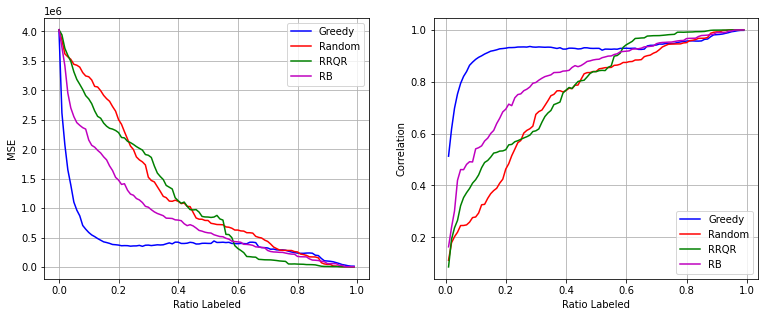

In [37]:
read_tntp_graph("data/Barcelona/Barcelona_flow.tntp")
plt.savefig("results/Barcelona_MSE.pdf")
plt.show()

  0%|          | 0/2950 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


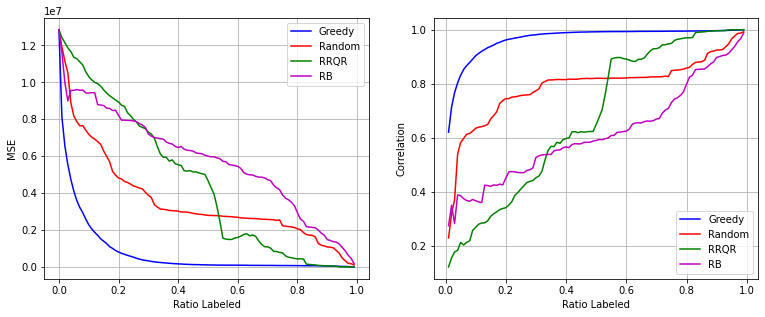

In [38]:
read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")
plt.savefig("results/Chicago_MSE.pdf")
plt.show()

  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


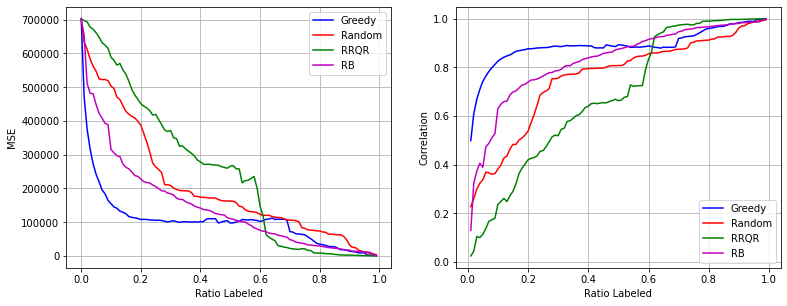

In [39]:
read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp")
plt.savefig("results/Winnipeg_MSE.pdf")
plt.show()